In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from vae import VAE
from tqdm import tqdm

import torchvision
import torchvision.datasets as datasets
from utils import train_model

torch.set_default_dtype(torch.float64)

/home/troch/miniconda3/envs/vae-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/troch/miniconda3/envs/vae-venv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/troch/miniconda3/envs/vae-venv/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
num_train = 60_000  # note cannot be greater than 60_000

mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
mnist_iter = iter(torch.utils.data.DataLoader(mnist, shuffle=True))

training_images = []
for _ in tqdm(range(num_train)):
    img = next(mnist_iter)[0].squeeze(0).permute(1, 2, 0)
    training_images.append(img)


100%|██████████| 60000/60000 [00:05<00:00, 10016.50it/s]


In [96]:
vae_model = VAE(
    latent_dim = 64,
    enc_hidden_dims = [100, 100],
    dec_hidden_dims = [100],
    noise = 'heteroscedastic',
) 

In [97]:
tracker = train_model(
    vae_model,
    training_images,
    batch_size=4,
    lr=1e-3,
    max_epochs=2000,
    early_stopping=True,
    )

epochs: 100%|██████████| 2000/2000 [05:57<00:00,  5.59it/s, elbo=3.35e+3, ll=3.61e+3, kl=258]  


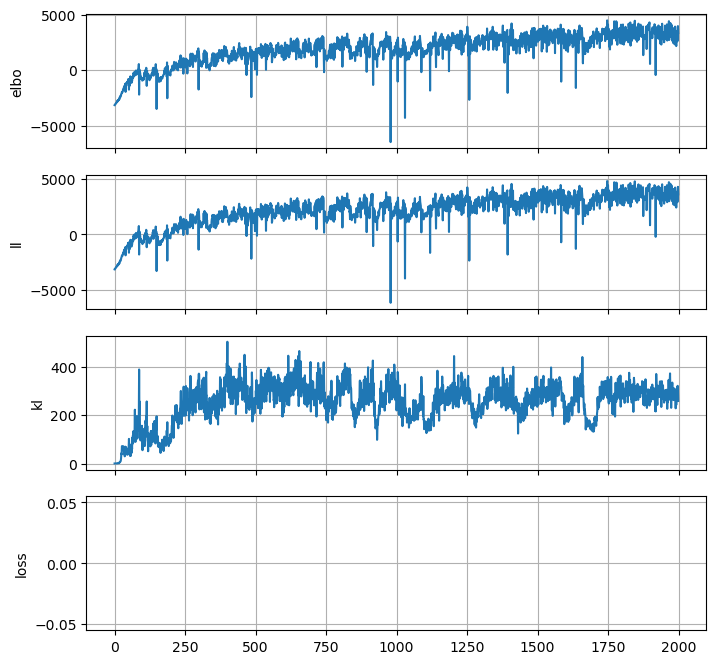

In [98]:
fig, axes = plt.subplots(
    len(tracker.keys()),
    1,
    figsize=(8, len(tracker.keys()) * 2),
    dpi=100,
    sharex=True,
)

for ax, (key, vals) in zip(axes, tracker.items()):
    ax.plot(vals)
    ax.set_ylabel(key)
    ax.grid()

plt.show()

In [99]:
torch.manual_seed(0)

num_test = 3

mnist_test = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
mnist_test_iter = iter(torch.utils.data.DataLoader(mnist_test, shuffle=False))

test_images = []
for _ in range(num_test):
    img = next(mnist_test_iter)[0].squeeze(0).permute(1, 2, 0)
    test_images.append(img.unsqueeze(0))

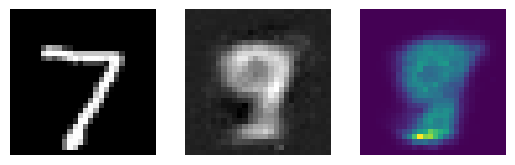

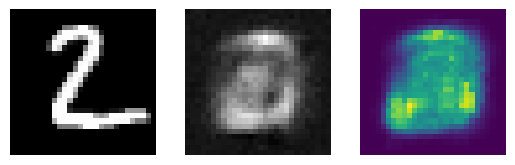

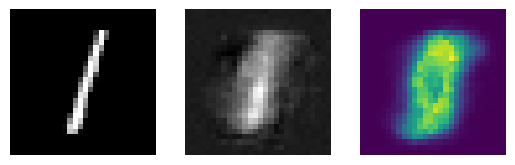

In [100]:
for image in test_images:
    with torch.no_grad():
        _, _, p = vae_model(image)
    reconstruction = p.loc.squeeze(0).squeeze(0).view(28, 28, 1)
    uncertainty = p.covariance_matrix.squeeze(0).squeeze(0).diag().view(28, 28, 1)
    
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(image.squeeze(0).numpy(), cmap="gray")
    axes[0].axis(False)
    axes[1].imshow(reconstruction.numpy(), cmap="gray")
    axes[1].axis(False)
    axes[2].imshow(uncertainty.numpy(), cmap="viridis")
    axes[2].axis(False)
    